In [1]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from visualization import state_visualization as state_vis
from math_utils import linear_algebra_utils as lau

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# In this notebook we sweep the dimension of the Hilbert space fixing a noise photon number of 4.4, a mesh size of 0.5, and a phase-space half-width of 6

# The estimate for the number of dimensions (Fock states) necessary comes from constraining the overlap between the greatest photon number Fock state and the coherent state in our mesh that is farthest from the origin to be 'small'

# The estimate for how wide our phase-space mesh should be comes from considering the photon number of our signal and the photon number distribution of our noise

<IPython.core.display.Javascript object>


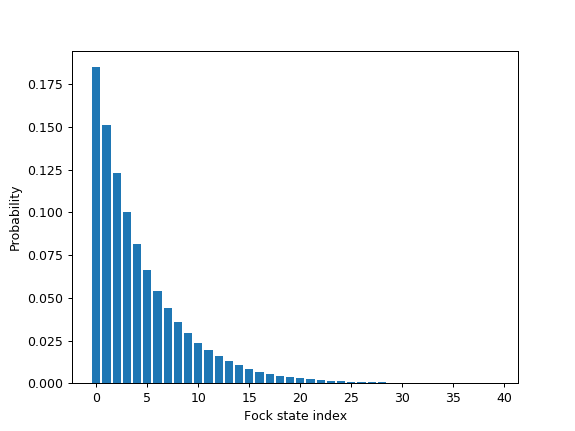

<IPython.core.display.Javascript object>


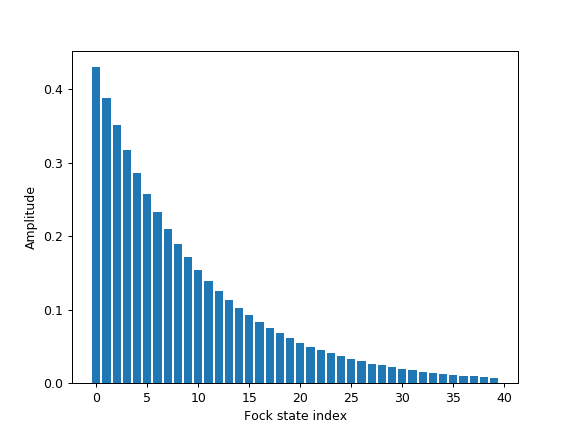

In [6]:
# First we see how many Fock states have nonnegligible weight in a thermal state of average photon number 4.4
dim = 40 # Generously large to ensure we resolve the entire thermal state
number_of_noise_photons = 4.4
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
state_vis.plot_fock_basis_probabilities(noise_state)
state_vis.plot_fock_basis_amplitudes(noise_state)

<IPython.core.display.Javascript object>


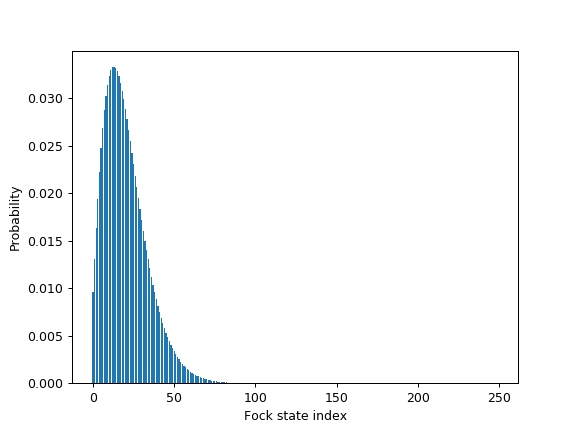

<IPython.core.display.Javascript object>


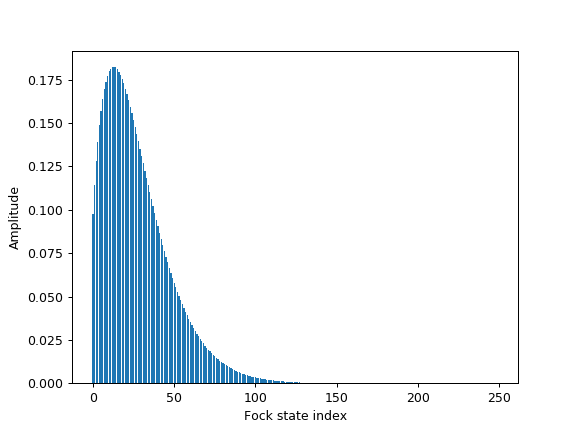

In [99]:
# We should also see what happens when we shift a thermal noise state of 4.4 photons on average
# to the corner of our mesh, as that will be the most extremal state of our noisy POVM

# Increase the dimension by like, a lot
dim = 250
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

corner_alpha = 4
shifted_noise_state = qutip.displace(dim, corner_alpha) * noise_state \
                    * qutip.displace(dim, corner_alpha).dag()
state_vis.plot_fock_basis_probabilities(shifted_noise_state)
state_vis.plot_fock_basis_amplitudes(shifted_noise_state)

In [ ]:
# It's clear from the above plot that we expect to need at the very least a dimension of 30 and 
# phase space width of sqrt(30). That's of course cutting things close, so we'll set the phase space width
# to be 6 corresponding to a max center photon number of 72. We'll start here to see the deliterious
# effects of not including enough basis states.

In [7]:
max_x = 5
mesh_size = 0.1
number_of_noise_photons = 4.4

# Define the range of dimensions
smallest_dim = 30
largest_dim = 120
stepsize = 10
dims = np.arange(smallest_dim, largest_dim + stepsize, stepsize)
dim = 150
dims = [dim]

noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

s = time.time()
noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim, 
                                                              noise_base=noise_state)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 268.0099890232086 seconds


In [8]:
# Sweep the dims and extract the results for each case
reconstructed_states = []
noisy_data_Q_functions = []
fidelities_per_dim = []
final_fidelities_per_dim = []
xs_per_dim = []
ps_per_dim = []

for dim in dims:
    # Define the noise
#    noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
    
    # THIS TAKES TOO LONG TO RUN OVER AND OVER AGAIN
    # Construct the noisy POVM that we'll use for tomography
#     noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
#                                                                   mesh_size, 
#                                                                   dim, 
#                                                                   noise_base=noise_state)
    xs_per_dim.append(xs)
    ps_per_dim.append(ps)

    # Define the input state and use the noise state to generate its noisy Q function
    #
    # The Q function of a state is its ideal input for coherent state POVM as it is literally
    # defined to be Q(alpha; rho) = 1/pi * (<alpha|rho|alpha>) = Tr(rho * POVM_alpha)
    input_state = (qutip.basis(dim, 0) + qutip.basis(dim, 1)).unit()
    noise_Q_function = qutip.qfunc(noise_state, xs, ps, g=2)
    noisy_data_Q_function = \
        cst.evaluate_thermally_noisy_Q_function(input_state, 
                                                number_of_noise_photons, 
                                                xs, 
                                                ps)
    noisy_data_Q_functions.append(noisy_data_Q_function)
    
    # Perform MLE
    number_of_mle_iterations = 2
    print('hi')
    s = time.time()
    reconstructed_state, fidelities = cst.perform_coherent_state_MLE(
                                        noisy_povm,
                                        noisy_data_Q_function, 
                                        number_of_mle_iterations,
                                        rho_ideal=input_state,
                                        identity_mixin=0)
    e = time.time()
    print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
    
    reconstructed_states.append(reconstructed_state)
    fidelities_per_dim.append(fidelities)
    final_fidelities_per_dim.append(fidelities[-1])

hi
2
Time for MLE reconstruction for dim = 150: 12.14726972579956 s


<IPython.core.display.Javascript object>


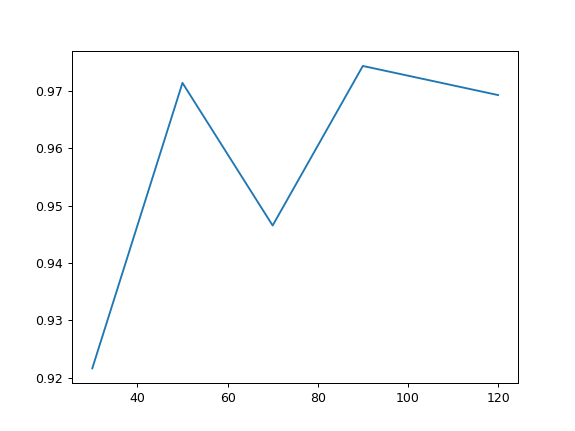

In [93]:
fig, ax = plt.subplots()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.plot(dims, final_fidelities_per_dim)

0.0


<IPython.core.display.Javascript object>


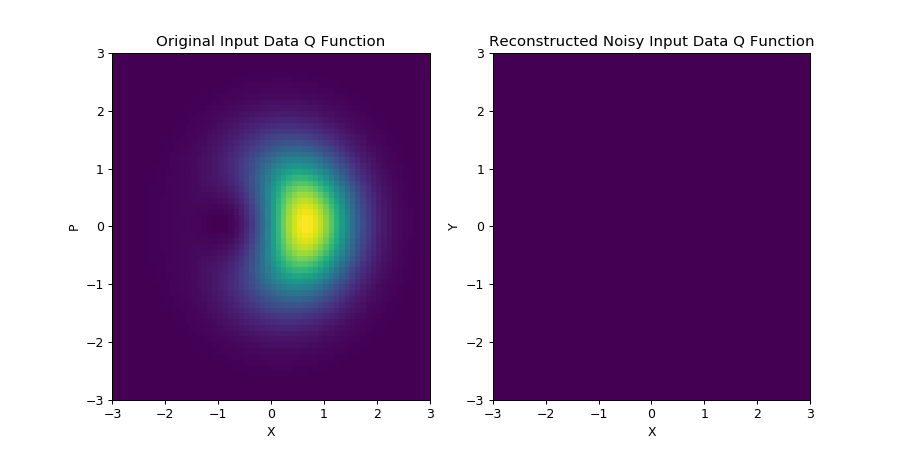

<IPython.core.display.Javascript object>


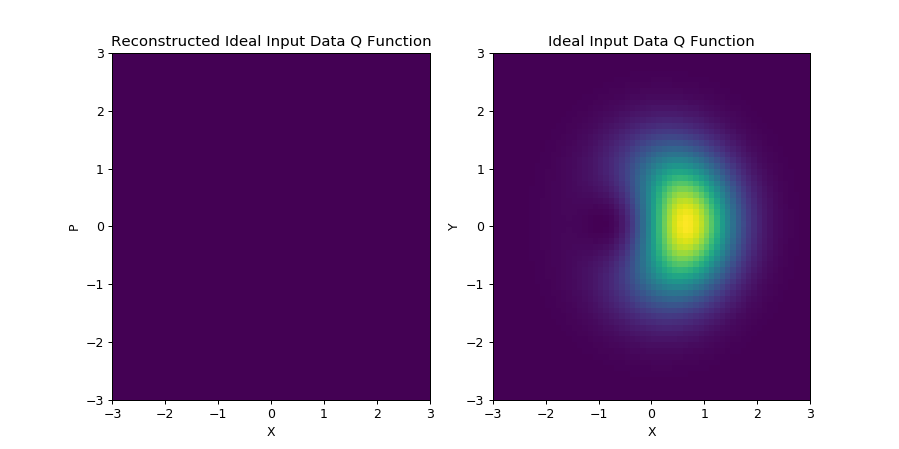

<IPython.core.display.Javascript object>


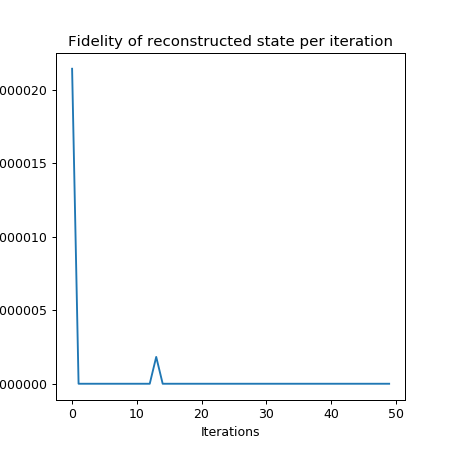

<IPython.core.display.Javascript object>


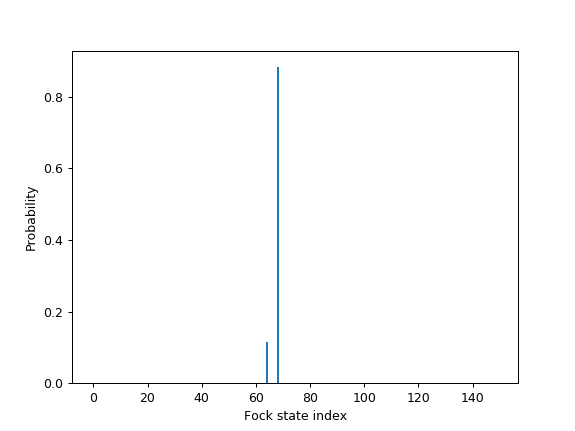

In [125]:
i = 0
rs = reconstructed_states[i]
ndQf = noisy_data_Q_functions[i]
fs = fidelities_per_dim[i]
xs = xs_per_dim[i]
ps = ps_per_dim[i]

print(fs[-1])

cst.plot_coherent_state_tomography_Q_functions(ndQf,
                                               rs,
                                               xs,
                                               ps,
                                               noise_photon_number=number_of_noise_photons,
                                               ideal_state=input_state,
                                               fidelities=fs)

state_vis.plot_fock_basis_probabilities(rs)

In [76]:
dim = rs.shape[0]
input_state = (qutip.basis(dim, 0) + qutip.basis(dim, 1)).unit()
qutip.tracedist(input_state, rs)

0.2199342896251994

# Stress testing numerical stability wrt Hilbert space dimensionality

In [65]:
# dim = 90
max_x = 6
mesh_size = 0.25
number_of_noise_photons = 4.4
dims = [40, 150]

In [74]:
min_G_inv_elements = []
max_G_inv_elements = []
G_inv_dets = []

min_G_elements = []
max_G_elements = []
G_dets = []
for dim in dims:
    # Define the noise
    noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

    # Construct the noisy POVM that we'll use for tomography
    noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                                  mesh_size, 
                                                                  dim, 
                                                                  noise_base=noise_state)

    # Get G matrix
    G = np.matrix(cst.sum_povm_elements(noisy_povm))
    min_G_elements.append(np.min(np.abs(G)))
    max_G_elements.append(np.max(np.abs(G)))
    G_dets.append(np.linalg.det(np.matrix(G)))
    
    
    # Get the G_inv matrix from the POVM
    G_inv = np.matrix(cst.extract_G_inv_from_POVM(noisy_povm))
    min_G_inv_elements.append(np.min(np.abs(G_inv)))
    max_G_inv_elements.append(np.max(G_inv))
    det_G_inv = np.linalg.det(np.matrix(G_inv))
    G_inv_dets.append(det_G_inv)
    
    print(np.allclose(np.dot(G, G_inv), np.identity(G.shape[0])))
    

True


<IPython.core.display.Javascript object>


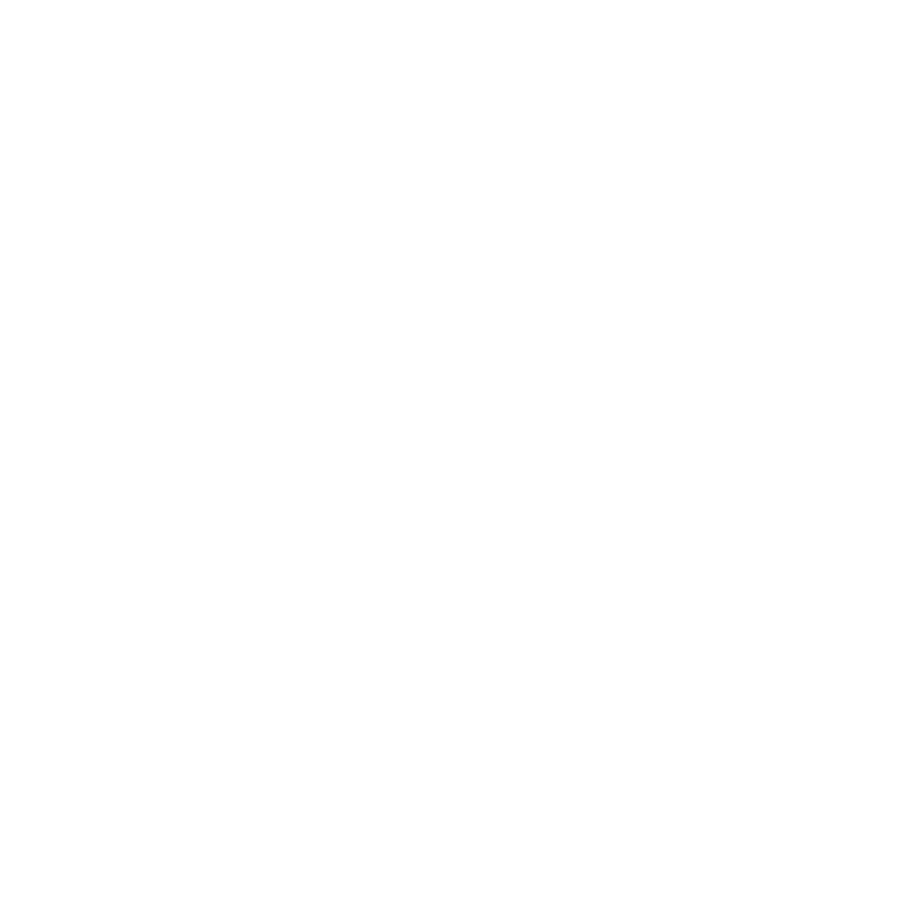

ValueError: x and y must be the same size

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].scatter(dims, min_G_inv_elements)
ax[0].set_title('Minimum elements of G_inv')
ax[1].scatter(dims, max_G_inv_elements)
ax[1].set_yscale('log')
ax[1].set_title('Maximum elements of G_inv')
ax[2].scatter(dims, G_inv_dets)
ax[2].scatter(dims, G_dets)

In [67]:
print(G_dets)

[(3.862347250433151e+51-1.3878452430268867e+33j), (169973175782.42242-5.697881226552225e-06j)]
